## Data Tester

The goal of this notebook is to validate the overall process of converting a .txt power trace file into tensors. It will also test the sampler function

### Current Issues

The current dataloader is using "string -> float64 -> float32" to translate string current values into float32 values.

The data sampler is a bit more complicated; it is using "string -> float32 -> string -> float64 -> float32" to first translate .txt values to float values for linerization and again string to floats to create dataloaders.

Goal is to identify the impact of automatic conversions potentially leading to value loss during these processes, and to clear out the logic for more accurate values.

#### Hyperparameter - Trace File Directories
All power trace files are assumed to be saved in a folder called 'trace_files' within the root directory of the notebook.

Define names of all folders within 'trace_files' to be added to the dataloaders within this hyperparameter.

In [1]:
''' 
Hyperparameter used to desginate trace folders to be loaded.
    1) sub_folder: BOOLEAN value that is used when trace folders are stored in a specific
    folder within the parent directory.
    2) sub_folder_name: name of sub-folder
    ex) If trace folders are stored in /trace_folders/analog_5px, set sub_folder to True
    and sub_folder_name to 'analog_5px'
    3) train_trace_folder_names: Add names of folders used for TRAINING dataset to this array.
    4) test_trace_folder_names: Add names of folders used for TESTING dataset to this array.
    5) trace_type: string that defines the type of trace file to be used. Default is "lin" for linearized.
    6) file_pattern: RegEx of file names to be checked. Number of groups MUST match 'adc_num'
'''
sub_folder = 'trace_files'
test_folder = "analog_1_tt_x"
train_trace_folder_names = ['analog_1_tt_x']
test_trace_folder_names = ['analog_1_tt_x']
trace_type_raw = "raw"
trace_type_lin = "lin"
digital_part_name = "_s\\d+_([0-9]+\\.[0-9]+)\\.txt"
raw_file_pattern = trace_type_raw + digital_part_name
lin_file_pattern = trace_type_lin + digital_part_name

### 1.1 Rain Check: Visualizing all RAW files

In [2]:
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

def get_files_in_directory(directory, file_pattern):
    """
    Get all files in the directory that match the regex pattern.
    """
    matched_files = []
    for filename in os.listdir(directory):
        if re.match(file_pattern, filename):
            matched_files.append(os.path.join(directory, filename))
    return matched_files

def read_file(file_path):
    """
    Reads a file containing two columns (time, current values).
    Returns two lists: times and currents.
    """
    times = []
    currents = []
    with open(file_path, 'r') as file:
        for line in file:
            values = line.split()
            if len(values) == 2:
                times.append(float(values[0]))
                currents.append(float(values[1]))
    return times, currents

def plot_files(files):
    """
    Plots all the files with time as x-axis and current as y-axis.
    Each file gets a different color.
    Also adds vertical blue and red lines at the min and max time values respectively.
    """
    min_time_arr = []
    max_time_arr = []
    plt.figure(figsize=(10, 6))
    
    for file_path in files:
        times, currents = read_file(file_path)
        
        plt.plot(times, currents, label=os.path.basename(file_path))
        
        min_time = min(times)
        min_time_arr.append(min_time)
        max_time = max(times)
        max_time_arr.append(max_time)
        
        plt.axvline(x=min_time, color='blue', linestyle='--', label=f"{os.path.basename(file_path)} Min Time ({min_time})")
        plt.axvline(x=max_time, color='red', linestyle='--', label=f"{os.path.basename(file_path)} Max Time ({max_time})")
    
    plt.xlabel('Time')
    plt.ylabel('Current')
    plt.title('Current - Time Values')
    # plt.legend(by_label.values(), by_label.keys(), loc='upper right')

    min_avg = 0
    max_avg = 0
    for i in min_time_arr:
        min_avg += i
    min_avg /= len(min_time_arr)
    for i in max_time_arr:
        max_avg += i
    max_avg /= len(max_time_arr)

    print("Minimum time stats:")
    print(f"Avg min time: {min_avg}")
    print(f"Minimum min time: {min(min_time_arr)}")
    print(f"Maximum min time: {max(min_time_arr)}\n")
    print("Maximum time stats:")
    print(f"Avg max time: {max_avg}")
    print(f"Minimum max time: {min(max_time_arr)}")
    print(f"Maximum max time: {max(max_time_arr)}\n")
    
    plt.grid(True)
    plt.show()

In [3]:
pwd = os.getcwd()
trace_folder_dir = os.path.join(pwd, 'trace_files')
trace_folder_dir = os.path.join(trace_folder_dir, test_folder)
files = get_files_in_directory(trace_folder_dir, raw_file_pattern)

# If there are files, plot them
if files:
    plot_files(files)
else:
    print(f"No files matching the pattern '{raw_file_pattern}' found in {trace_folder_dir}.")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/calya/Desktop/PowerTraces/CNN_PSA_ResNet/trace_files/analog_1_tt_x'

### 1.1 Conclusion - All PT files have the same starting time and roughly similar ending times; the differences are small enough to be negligible.

I am taking another look into the linearization logic to double check any potential issues.

### 1.2 Difference between float(), np.float32() and np.float64

In [ ]:
# Necessary imports
import random
import numpy as np

### 1.2 Helper Functions - float(), float32(), float64() Casting

In [ ]:
''' 
Function that casts all string elements to float using float()
Inputs:
    1) current_str_arrs: value string array
Returns:
    1) result: casted float array
'''
def float_cast(current_str_arrs):
    return [list(map(lambda x: float(x), current_str_arr)) for current_str_arr in current_str_arrs]

''' 
Function that casts all string elements to float using np.float32()
Inputs:
    1) current_str_arrs: value string array
Returns:
    1) result: casted float array
'''
def float32_cast(current_str_arrs):
    return [list(map(lambda x: np.float32(x), current_str_arr)) for current_str_arr in current_str_arrs]

''' 
Function that casts all string elements to float using np.float64()
Inputs:
    1) current_str_arrs: value string array
Returns:
    1) result: casted float array
'''
def float64_cast(current_str_arrs):
    return [list(map(lambda x: np.float64(x), current_str_arr)) for current_str_arr in current_str_arrs]

### 1.2 Testing: Differences in Casting?

np.float32(val1) vs f"{np.float32(val1)}":

np.float32(val1) prints the OBJECT that is converted automatically using the object's inherent 'print' method.

f"{np.float32(val1)}" casts the object as a STRING and prints that directly.

In [ ]:
# Testing float32 for same values with different exponential values
# Gonna use strings
val1 = '1.1234512345e-2'
val2 = '112345.12345e-7'
val3 = '1.1234512345e-13'
val_arr = []
val_arr.append(val1)
val_arr.append(val2)
val_arr.append(val3)

print("Printing np.float32 casting:")
print(f"{np.float32(val1)}")
print(f"{np.float32(val2)}")
print(f"{np.float32(val3)}")
print()
print("Printing np.float64 casting:")
print(f"{np.float64(val1)}")
print(f"{np.float64(val2)}")
print(f"{np.float64(val3)}")
print()
print("Printing np.float64(np.float32) casting:")
print(f"{np.float64(np.float32(val1))}")
print(f"{np.float64(np.float32(val2))}")
print(f"{np.float64(np.float32(val3))}")
print()
print("Printing np.float32(np.float64) casting:")
print(f"{np.float32(np.float64(val1))}")
print(f"{np.float32(np.float64(val2))}")
print(f"{np.float32(np.float64(val3))}")
print()
print("Printing difference between float32 and float64 value:")
print(f"{abs(np.float64(val1) - np.float32(val1))}")
print(f"{abs(np.float64(val2) - np.float32(val2))}")
print(f"{abs(np.float64(val3) - np.float32(val3))}")

# Now try multipling ALL values with min exponent; in this case, 13
# Rather than running the function, will do it manually
val1 = '1.1234512345e+11'
val2 = '112345.12345e+6'
val3 = '1.1234512345e+0'

print("VALUE UPDATED")
print()
print("Printing np.float32 casting:")
print(f"{np.float32(val1)}")
print(f"{np.float32(val2)}")
print(f"{np.float32(val3)}")
print()
print("Printing np.float64 casting:")
print(f"{np.float64(val1)}")
print(f"{np.float64(val2)}")
print(f"{np.float64(val3)}")
print()
print("Printing np.float64(np.float32) casting:")
print(f"{np.float64(np.float32(val1))}")
print(f"{np.float64(np.float32(val2))}")
print(f"{np.float64(np.float32(val3))}")
print()
print("Printing np.float32(np.float64) casting:")
print(f"{np.float32(np.float64(val1))}")
print(f"{np.float32(np.float64(val2))}")
print(f"{np.float32(np.float64(val3))}")
print()
print("Printing difference between float32 and float64 value:")
print(f"{abs((np.float64(val1) - np.float32(val1)) / pow(10,13))}")
print(f"{abs((np.float64(val2) - np.float32(val2)) / pow(10,13))}")
print(f"{abs((np.float64(val3) - np.float32(val3)) / pow(10,13))}")

Printing np.float32 casting:
0.01123451255261898
0.01123451255261898
1.1234512398063806e-13

Printing np.float64 casting:
0.011234512345
0.011234512345
1.1234512345e-13

Printing np.float64(np.float32) casting:
0.01123451255261898
0.01123451255261898
1.1234512398063806e-13

Printing np.float32(np.float64) casting:
0.01123451255261898
0.01123451255261898
1.1234512398063806e-13

Printing difference between float32 and float64 value:
2.0761898103516252e-10
2.0761898103516252e-10
5.306380668923225e-22
VALUE UPDATED

Printing np.float32 casting:
112345120768.0
112345120768.0
1.1234512329101562

Printing np.float64 casting:
112345123450.0
112345123450.0
1.1234512345

Printing np.float64(np.float32) casting:
112345120768.0
112345120768.0
1.1234512329101562

Printing np.float32(np.float64) casting:
112345120768.0
112345120768.0
1.1234512329101562

Printing difference between float32 and float64 value:
2.682e-10
2.682e-10
1.5898438121553226e-22


### 1.2 Conclusion
Thus, the results are as follows:

1) The rounding to float32 happens regardless of casting from string or float64.
2) If the exponent is smaller, the RELATIVE overshooting values tend to get larger.
3) On the other hand, if the exponent is larger, the OBJECTIVE overshooting values tend to get larger.
    - This explains why the multiplication of min exponent to all values tended to increase accuracy; basically we are increasing the RELATIVE accuracy of each value.


Therefore, we can make these conclusions:
1) No need to use double casting; they produce the same result
2) Need to multiply all values with SMALLEST exponent value to normalize them. This gives two benefits:
    - First, it makes larger values larger and smaller values closer to its true value.
    - Second, it makes calculations a lot easier for PyTorch, and potentially minimizes the vanishing gradient problem; however, it may result in an exploding gradient problem.
    - Thus, probably will be better to use the AVERAGE exponent value.

ONE THING TO NOTE: the current approach of FIXING the amount of exponent multiplied is better, as different exponent values multiplied to each power trace will produce varying inputs.
Thus, I'll just change the current implementation of manually setting the multiplied exponent to automatically get the AVERAGE exponent value out of all power traces.

### 1.2 Testing: Checking effects of Casting -> String -> Casting

In [ ]:
val1 = '1.1234512345e-2'
val2 = '112345.12345e-7'
val3 = '1.1234512345e-13'

print("Printing np.float32 casting:")
print(f"{np.float32(val1)}")
print(f"{np.float32(val2)}")
print(f"{np.float32(val3)}\n")

print("Printing np.float64 casting:")
print(f"{np.float64(val1)}")
print(f"{np.float64(val2)}")
print(f"{np.float64(val3)}\n")

# Current sampler implementation = str -> float32 -> str -> float64 -> float32
print("Printing np.float32(np.float64(str(np.float32))) casting:")
print(f"{np.float32(np.float64(str(np.float32(val1))))}")
print(f"{np.float32(np.float64(str(np.float32(val2))))}")
print(f"{np.float32(np.float64(str(np.float32(val3))))}")
print()

print("Printing np.float32(str(np.float32)) casting:")
print(f"{np.float32(str(np.float32(val1)))}")
print(f"{np.float32(str(np.float32(val2)))}")
print(f"{np.float32(str(np.float32(val3)))}")
print()

Printing np.float32 casting:
0.01123451255261898
0.01123451255261898
1.1234512398063806e-13

Printing np.float64 casting:
0.011234512345
0.011234512345
1.1234512345e-13

Printing np.float32(np.float64(str(np.float32))) casting:
0.01123451255261898
0.01123451255261898
1.1234512398063806e-13

Printing np.float32(str(np.float32)) casting:
0.01123451255261898
0.01123451255261898
1.1234512398063806e-13



### 1.2 Conclusion: value loss always happens when converting values with more than 7 digits from either string or float64 to float32.

Thus, double casting from float64 to 32 is unnecessary.

### 1.3 Testing Accuracy between Automatic Conversion or Manually Dropping Digits

### 1.3 Helper Functions - Value Stripping Methods

In [ ]:
def read_file_string(file_path):
    """
    Reads a file containing two columns (time, current values).
    Returns two lists: times and currents, saved as raw strings
    """
    times = []
    currents = []
    with open(file_path, 'r') as file:
        for line in file:
            values = line.split()
            if len(values) == 2:
                times.append(values[0])
                currents.append(values[1])
    return times, currents

In [ ]:
def plot_pt(pt_arr):
    """
    Plots all pt values in pt_arr with time as x-axis and current as y-axis.
    Each pt gets a different color.
    """

    plt.figure(figsize=(10, 6))
    
    for idx, pt in enumerate(pt_arr):
        plt.plot(pt, label=f'Line {idx + 1}')
    
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Current - Time Values')
    
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.ion()
    plt.show()

    plt.pause(0.1)

In [ ]:
# Testing dropping digits vs automatic casting
# Use existing process_string function with slight modifications

# NEW IDEA: can we try straightforward binary format?
# 1) Function that uses np.frexp, np.lrexp to strip float32 to its mantissa and exponent value
def process_string_drop(val_string_arr):
    mantissa_arr = []
    exp_arr = []
    result = []
    for i in val_string_arr:
        try:
            match = re.search(r"(?<=e-)\d+", i)
            if match:
                float_val = np.float32(i)
                mantissa, exponent = np.frexp(float_val)
                mantissa_arr.append(mantissa)
                exp_arr.append(exponent)
        except ValueError as e:
            print(f"Error parsing value '{i}': {e}")

    min_exp = min(exp_arr)
    exp_arr = [list(map(lambda x: x - min_exp, exp_arr))]
    result = [list(map(lambda x, y: np.ldexp(x, y), mantissa_arr, exp_arr))]
    return result

In [ ]:
# 2) Function that uses the classic approach with automatic casting.
# Separate string to digits and exponent, and cast normalized value to float32
def strip_and_get_exp_32(current):
    result = []
    e_val = []
    # First iteration: go through all values, strip with value and e value, get avg e value
    for value in current:
        # Edge case: value is "-0.00000000e+00" or "0.00000000e+00"
        # Add more edge cases if needed
        if value in ["-0.00000000e+00", "0.00000000e+00"]:
            # append string to result, int to e_val
            result.append('0')
            e_val.append(0)
        else:
            try:
                match = re.search(r"(?<=e-)\d+", value)
                if match:
                    if value[0] == "-":
                        strip_val = value[0:11]
                        strip_val_e = value[12:15]
                    else:
                        strip_val = value[0:10]
                        strip_val_e = value[11:14]
                    # value must be remained as string
                    result.append(np.float32(strip_val))
                    # e_val casted to string to get avg
                    e_val.append(int(strip_val_e))
                    '''
                    # Debugging scripts; do not erase
                    print(f"\tstrip_val: {strip_val}")
                    print(f"\tstrip_val_e: {strip_val_e}\n")
                    new_val = process_string(strip_val, strip_val_e)
                    print(f"\tProcessed: {new_val}")
                    print(f"\tFloat32 of processed: {np.float32(new_val)}\n")
                    '''
            except ValueError as e:
                print(f"Error parsing value '{value}': {e}")
    e_min = min(e_val)
    result = list(map(lambda x: x * e_min, result))
    return result


In [ ]:
# 3) Function that uses the classic approach with automatic casting.
# Separate string to digits and exponent, and cast normalized value to float64 then float32
def strip_and_get_exp_64_32(current):
    result = []
    e_val = []
    # First iteration: go through all values, strip with value and e value, get avg e value
    for value in current:
        # Edge case: value is "-0.00000000e+00" or "0.00000000e+00"
        # Add more edge cases if needed
        if value in ["-0.00000000e+00", "0.00000000e+00"]:
            # append string to result, int to e_val
            result.append('0')
            e_val.append(0)
        else:
            try:
                match = re.search(r"(?<=e-)\d+", value)
                if match:
                    if value[0] == "-":
                        strip_val = value[0:11]
                        strip_val_e = value[12:15]
                    else:
                        strip_val = value[0:10]
                        strip_val_e = value[11:14]
                    # value must be remained as string
                    result.append(np.float32(np.float64(strip_val)))
                    # e_val casted to string to get avg
                    e_val.append(int(strip_val_e))
                    '''
                    # Debugging scripts; do not erase
                    print(f"\tstrip_val: {strip_val}")
                    print(f"\tstrip_val_e: {strip_val_e}\n")
                    new_val = process_string(strip_val, strip_val_e)
                    print(f"\tProcessed: {new_val}")
                    print(f"\tFloat32 of processed: {np.float32(new_val)}\n")
                    '''
            except ValueError as e:
                print(f"Error parsing value '{value}': {e}")
    e_min = min(e_val)
    result = list(map(lambda x: x * e_min, result))
    return result


In [ ]:
# 4) Function that uses the new approach of rounding up values.
# Separate string to digits and exponent, round value and convert string to float32
def strip_and_round_32(current):
    result = []
    e_val = []
    # First iteration: go through all values, strip with value and e value, get avg e value
    for value in current:
        # Edge case: value is "-0.00000000e+00" or "0.00000000e+00"
        # Add more edge cases if needed
        if value in ["-0.00000000e+00", "0.00000000e+00"]:
            # append string to result, int to e_val
            result.append('0')
            e_val.append(0)
        else:
            try:
                match = re.search(r"(?<=e-)\d+", value)
                if match:
                    if value[0] == "-":
                        strip_val = value[0:11]
                        strip_val_e = value[12:15]
                    else:
                        strip_val = value[0:10]
                        strip_val_e = value[11:14]
                    # value must be remained as string
                    rounded_value = round(strip_val, 7)
                    result.append(np.float32(rounded_value))
                    # e_val casted to string to get avg
                    e_val.append(int(strip_val_e))
                    '''
                    # Debugging scripts; do not erase
                    print(f"\tstrip_val: {strip_val}")
                    print(f"\tstrip_val_e: {strip_val_e}\n")
                    new_val = process_string(strip_val, strip_val_e)
                    print(f"\tProcessed: {new_val}")
                    print(f"\tFloat32 of processed: {np.float32(new_val)}\n")
                    '''
            except ValueError as e:
                print(f"Error parsing value '{value}': {e}")
    e_min = min(e_val)
    result = list(map(lambda x: x * e_min, result))
    return result


In [ ]:
# 5) Function that uses the new approach of rounding up values.
# Separate string to digits and exponent, round value and convert string to float64 then float32
def strip_and_round_64_32(current):
    result = []
    e_val = []
    # First iteration: go through all values, strip with value and e value, get avg e value
    for value in current:
        # Edge case: value is "-0.00000000e+00" or "0.00000000e+00"
        # Add more edge cases if needed
        if value in ["-0.00000000e+00", "0.00000000e+00"]:
            # append string to result, int to e_val
            result.append('0')
            e_val.append(0)
        else:
            try:
                match = re.search(r"(?<=e-)\d+", value)
                if match:
                    if value[0] == "-":
                        strip_val = value[0:11]
                        strip_val_e = value[12:15]
                    else:
                        strip_val = value[0:10]
                        strip_val_e = value[11:14]
                    # value must be remained as string
                    rounded_value = round(strip_val, 7)
                    result.append(np.float32(np.float64(rounded_value)))
                    # e_val casted to string to get avg
                    e_val.append(int(strip_val_e))
                    '''
                    # Debugging scripts; do not erase
                    print(f"\tstrip_val: {strip_val}")
                    print(f"\tstrip_val_e: {strip_val_e}\n")
                    new_val = process_string(strip_val, strip_val_e)
                    print(f"\tProcessed: {new_val}")
                    print(f"\tFloat32 of processed: {np.float32(new_val)}\n")
                    '''
            except ValueError as e:
                print(f"Error parsing value '{value}': {e}")
    e_min = min(e_val)
    result = list(map(lambda x: x * e_min, result))
    return result


### 1.3 Testing

In [ ]:
import random

In [ ]:
val_arr = ["1.123451234e-5", "2.123451234e-3", "3.123451234e-7"]


# Test the new approach
print(process_string_drop(val_arr))
print()
print(list(map(lambda x: np.float64(x), process_string_drop(val_arr))))

[[array([2.356048e+01, 6.031483e+03, 7.362650e-01], dtype=float32)]]

[array([[2.35604801e+01, 6.03148291e+03, 7.36265004e-01]])]


In [ ]:
# Get lin files and choose 10 random pt files
files = get_files_in_directory(trace_folder_dir, lin_file_pattern)
file_len = len(files)

random_pts = []
file_current_vals = []

random_pts = random.sample(files, min(10, len(files)))

# Get all current values of pt files
for pt_file in random_pts:
    file_current_vals.append(read_file_string(pt_file)[1])

FileNotFoundError: [Errno 2] No such file or directory: '/Users/calya/Desktop/PowerTraces/CNN_PSA_ResNet/trace_files/analog_1_tt_x'

In [ ]:
# Get stripped vals
float32_arr = []
float64_32_arr = []
float32_round_arr = []
float64_32_round_arr = []
for file_current_val in file_current_vals:
    float32_arr.append(strip_and_get_exp_32(file_current_val))
    float64_32_arr.append(strip_and_get_exp_64_32(file_current_val))
    float32_round_arr.append(strip_and_round_32(file_current_val))
    float64_32_round_arr.append(strip_and_round_64_32(file_current_val))

NameError: name 'file_current_vals' is not defined

In [ ]:
# Using pandas to analyze data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame from the arrays
df = pd.DataFrame({
    'float32': float32_arr,
    'float64_32': float64_32_arr,
    'float32_round': float32_round_arr,
    'float64_32_round': float64_32_round_arr
})

# Compute differences
df['diff_float32_vs_float64_32'] = df['float32'] - df['float64_32']
df['diff_float32_round_vs_float64_32_round'] = df['float32_round'] - df['float64_32_round']

# Melt the DataFrame for plotting
melted_df = df.melt(var_name='Array Type', value_name='Value')

# Plot setup
sns.set(style='whitegrid', context='paper', palette='pastel')
plt.figure(figsize=(12, 8))

# Plot 1: Distribution of values
plt.subplot(2, 2, 1)
sns.histplot(melted_df, x='Value', hue='Array Type', multiple='dodge', bins=50, log_scale=(False, True))
plt.title('Distribution of Values (Log Y-Axis)')

# Plot 2: Differences between original arrays
plt.subplot(2, 2, 2)
sns.violinplot(data=df[['diff_float32_vs_float64_32', 'diff_float32_round_vs_float64_32_round']].melt(var_name='Comparison', value_name='Difference'))
plt.title('Differences Between Arrays')
plt.yscale('symlog', linthresh=1e-15)
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)

# Plot 3: Swarm plot of differences
plt.subplot(2, 2, 3)
sns.swarmplot(data=df[['diff_float32_vs_float64_32', 'diff_float32_round_vs_float64_32_round']].melt(var_name='Comparison', value_name='Difference'), 
              y='Difference', x='Comparison', dodge=True)
plt.yscale('symlog', linthresh=1e-15)
plt.title('Individual Differences')

# Plot 4: Boxen plot of absolute differences
plt.subplot(2, 2, 4)
sns.boxenplot(data=df[['diff_float32_vs_float64_32', 'diff_float32_round_vs_float64_32_round']].abs().melt(var_name='Comparison', value_name='|Difference|'), 
              x='Comparison', y='|Difference|')
plt.yscale('log')
plt.title('Absolute Differences (Log Scale)')

# Add summary statistics
stats = df[['diff_float32_vs_float64_32', 'diff_float32_round_vs_float64_32_round']].agg(['mean', 'max', 'min', 'std'])
print("Difference Statistics:")
print(stats)

plt.tight_layout()
plt.show()

NameError: name 'float32_arr' is not defined

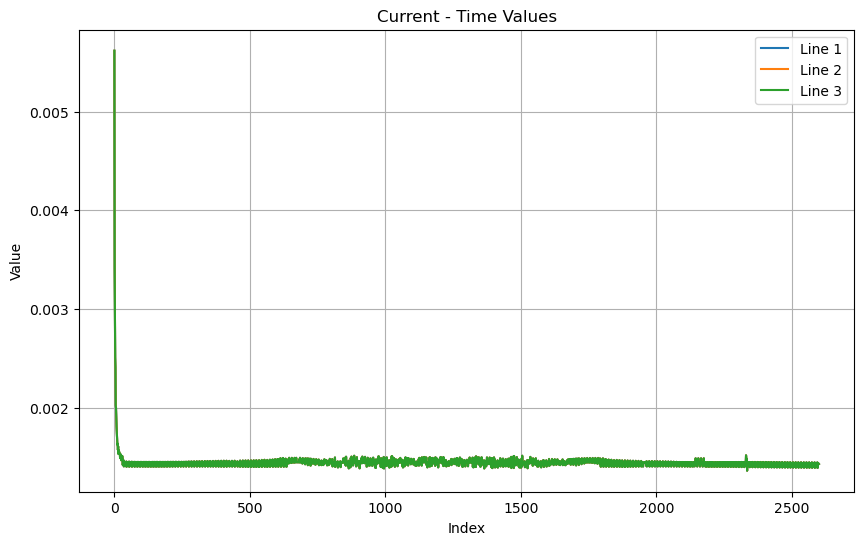

In [ ]:
# Take closer look at first value of each array
pt_arr = []
pt_arr.append(float_cast_arr[0])
pt_arr.append(float32_cast_arr[0])
pt_arr.append(float64_cast_arr[0])

plot_pt(pt_arr)

### 1.2 Conclusion: 

2.99011884093988e-08 ~= 0.00000003 value differences for a 9 significant-bit value casting of string to float32.

This is for every trace value; it may be insignificant, but if such casting is repeated twice once more in the subsampler, it may create larger differences.

The ONLY effective process was normalizing the exponent values and thus giving float32 more exponent headroom to calculate the values.


### 2. Sampler Test
Testing sampler method to find any potential issues

### Creating dataloaders

In [ ]:
# subsampler.py
import numpy as np
import matplotlib.pyplot as plt

DTYPE = np.float32

def select_func_gen(mode):
    def bmin(t1, v1, t2, v2, t): return v1
    def bmax(t1, v1, t2, v2, t): return v2
    def vmin(t1, v1, t2, v2, t): return min(v1, v2)
    def vmax(t1, v1, t2, v2, t): return max(v1, v2)
    def near(t1, v1, t2, v2, t): return v1 if t - t1 > t2 - t else v2
    def mlin(t1, v1, t2, v2, t): return (t-t1)/(t2-t1) * (v2-v1) + v1

    if mode == "BMIN": return bmin
    elif mode == "BMAX": return bmax
    elif mode == "VMIN": return vmin
    elif mode == "VMAX": return vmax
    elif mode == "NEAREST": return near
    elif mode == "LINEAR": return mlin
    else: raise ValueError("Illegal mode selected")

def sample_func_gen(mode):
    if   mode == 'MIN': return lambda x: np.min(x)
    elif mode == 'MAX': return lambda x: np.max(x)
    elif mode == 'AVG': return lambda x: np.average(x)
    else: raise ValueError("Illegal mode selected")
def sample_file(fpath, sample_interval, max_samples, sample_mode="AVG", column=0):
    time_col = column << 1
    valu_col = time_col + 1

    f = sample_func_gen(sample_mode)
    l = select_func_gen('LINEAR')

    tstart = 0
    tstop  = 1

    with open(fpath, 'r') as file:
        header = file.readline()

        tim_arr = [] # For debugging
        val_arr = []
        val_win = []

        stim, value = file.readline().strip().split()
        stim = DTYPE(stim)
        tstart = stim
        value = DTYPE(value)
        ptim = stim
        wtim = stim + sample_interval
        val_win.append(value)
        val_arr.append(value)
        tim_arr.append(ptim)

        for line in file.readlines():
            if len(val_arr) == max_samples: break
            stim, value = line.strip().split()
            stim  = DTYPE(stim)
            value = DTYPE(value)

            if stim >= wtim:
                val_arr.append(f(val_win))
                tim_arr.append(wtim - sample_interval/2)

                # if time is too big a gap:
                wtim += sample_interval
                while stim > wtim:
                    val_arr.append(l(ptim, val_arr[-1], stim, value, (len(val_arr)+0.5)*sample_interval))
                    tim_arr.append(wtim - sample_interval/2)
                    wtim += sample_interval

                val_win = [value]

            else:
                val_win.append(value)

            ptim = stim

        if (len(val_arr) < max_samples) and val_win:
            val_arr.append(f(val_win))
            tim_arr.append(ptim)

        if len(val_arr) < max_samples:
            # val_win is empty, latest wtim is handled
            x0, x1 = tim_arr[-2:]
            y0, y1 = val_arr[-2:]
            m = (y1 - y0)/(x1 - x0)

            wtim = wtim + sample_interval/2
            for i in range(max_samples - len(val_arr)):
                val_arr.append(y1:=((wtim - x1)*m+y1))
                tim_arr.append(x1:=wtim)
                wtim += sample_interval

        if len(val_arr) < max_samples:
            for i in range(40):
                print(i, tim_arr[i], val_arr[i], sep="\t")
            for i in range(40, 0, -1):
                print(-i, tim_arr[-i], val_arr[-i], sep="\t")
            exit()

        tstop = wtim

        return val_arr, tstart, tstop